In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import adam_v2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.densenet import DenseNet121
import tensorflow as tf
from keras import backend as K


seed=1
%matplotlib inline

In [4]:
trainpath = ('/content/drive/MyDrive/Machine  Learning/Pneumonia/input/chest-xray-pneumonia/chest_xray/train')
testpath = ('/content/drive/MyDrive/Machine  Learning/Pneumonia/input/chest-xray-pneumonia/chest_xray/test')
valpath = ('/content/drive/MyDrive/Machine  Learning/Pneumonia/input/chest-xray-pneumonia/chest_xray/val')

In [5]:
disease=["NORMAL","PNEUMONIA"]
img_size=224
train_dir = os.path.join(trainpath)
val_dir=os.path.join(valpath)
test_dir=os.path.join(testpath)

In [6]:
def get_data(filepath):
    data=[]
    for did, sp in enumerate(disease):
        for file in os.listdir(os.path.join(filepath, sp)):
            data.append(['{}/{}'.format(sp, file), did, sp])
    data = pd.DataFrame(data, columns=['File', 'DiseaseID','Disease Type'])
    data.head()
    return data

In [7]:
train=get_data(train_dir)
val=get_data(val_dir)
test=get_data(test_dir)

In [8]:
train.head()

,File,DiseaseID,Disease Type
0,NORMAL/IM-0535-0001.jpeg,0,NORMAL
1,NORMAL/IM-0538-0001.jpeg,0,NORMAL
2,NORMAL/IM-0537-0001.jpeg,0,NORMAL
3,NORMAL/IM-0522-0001.jpeg,0,NORMAL
4,NORMAL/IM-0539-0001-0001.jpeg,0,NORMAL


In [9]:
train = train.sample(frac=1, random_state=seed) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,NORMAL/IM-0549-0001-0002.jpeg,0,NORMAL
1,PNEUMONIA/person653_bacteria_2545.jpeg,1,PNEUMONIA
2,PNEUMONIA/person1457_virus_2498.jpeg,1,PNEUMONIA
3,NORMAL/IM-0348-0001.jpeg,0,NORMAL
4,PNEUMONIA/person1609_bacteria_4236.jpeg,1,PNEUMONIA


In [10]:
count=train["Disease Type"].value_counts()
print(count)

PNEUMONIA    3875
NORMAL       1341
Name: Disease Type, dtype: int64


In [11]:
def plot_imgs(filepath,distype):
    defect_files = train['File'][train["Disease Type"]==distype].values
    n = 0
    fig = plt.figure(figsize=(16,4))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(16):
        ax = fig.add_subplot(2, 8, i + 1, xticks=[], yticks=[])
        image_path = os.path.join(filepath, defect_files[i])
        img=plt.imread(image_path)
        plt.imshow(img,cmap='gray')
    plt.show()

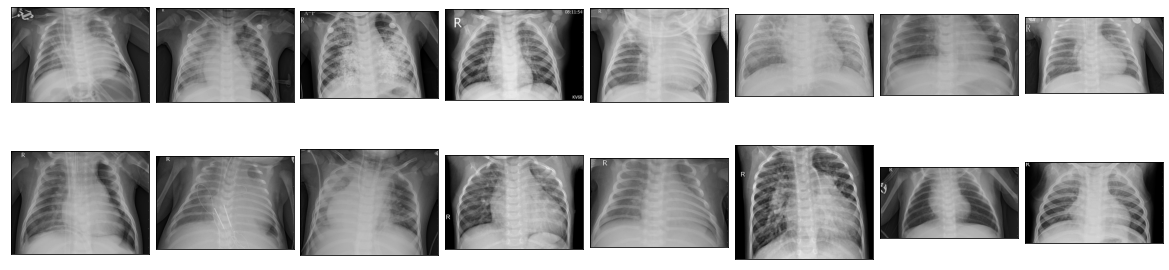

In [12]:
plot_imgs(train_dir,"PNEUMONIA")

In [13]:
image_size=224
batch_size=16

In [14]:
def read_image(filepath,whichset):
    return cv2.imread(os.path.join(whichset,filepath))

In [15]:
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [16]:
def get_train_valid_generator(df, image_dir,shuffle=True):

    print("getting train generator...") 
    x_cols="File"
    y_cols="DiseaseID"
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        validation_split=0.1,
        zoom_range = 0.2,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = True,
        rescale = 1./255
    )
    
    train_generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_cols,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=True,
            seed=seed,
            target_size=(image_size,image_size),
            subset='training'
    )
    valid_generator=image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_cols,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(image_size,image_size),
            subset='validation'
    )
    
    return train_generator,valid_generator

In [17]:
train_data,valid_data=get_train_valid_generator(train,train_dir)

getting train generator...
Found 4695 validated image filenames.
Found 521 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


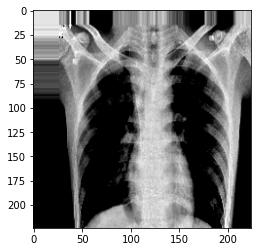

In [18]:
xtemp, ytemp = train_data.__getitem__(0)
plt.imshow(xtemp[0])

In [19]:
def get_test_data(df,image_dir,shuffle):
    x_cols="File"
    y_cols="DiseaseID"
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        rescale=1./255
    )
    
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_cols,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(image_size,image_size),
            
    )
    return generator
test_data=get_test_data(test,test_dir,False)

Found 624 validated image filenames.


In [20]:
N=4695 

In [21]:
def compute_freq(labels):
    positive_cases=np.sum(labels)/N
    negative_cases=1-positive_cases
    return positive_cases,negative_cases

In [22]:
pos_weights,neg_weights=compute_freq(train_data.labels)
print(pos_weights,neg_weights)

0.7410010649627263 0.25899893503727367


In [23]:
def get_weighted_loss(pos_weights, neg_weights):
    epsilon=1e-7
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos_weights)):
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        return loss
    return weighted_loss

In [24]:
base_model = DenseNet121(weights='imagenet', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)
x=Dropout(0.5)(x)
x=Dense(256,activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.5)(x)

# and a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

29097984/29084464 [==============================] - 0s 0us/step


In [25]:
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping, LearningRateScheduler
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
annealer = LearningRateScheduler(scheduler, verbose=1)

rlrplateau = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1, min_lr=1e-5)
checkpoint = ModelCheckpoint('mymodel.h5', verbose=1, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_accuracy',restore_best_weights=True, patience=3,verbose=1,mode='auto')

history = model.fit_generator(train_data,validation_data=valid_data,epochs = 10,verbose=1,callbacks=[annealer,checkpoint])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
294/294 [==============================] - ETA: 0s - loss: 0.3483 - accuracy: 0.8760
Epoch 1: val_loss improved from inf to 0.69927, saving model to mymodel.h5
294/294 [==============================] - 541s 2s/step - loss: 0.3483 - accuracy: 0.8760 - val_loss: 0.6993 - val_accuracy: 0.7466 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/10
294/294 [==============================] - ETA: 0s - loss: 0.2177 - accuracy: 0.9191
Epoch 2: val_loss improved from 0.69927 to 0.56304, saving model to mymodel.h5
294/294 [==============================] - 173s 588ms/step - loss: 0.2177 - accuracy: 0.9191 - val_loss: 0.5630 - val_accuracy: 0.8081 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/10
294/294 [==============================] - ETA: 0s - loss: 0.1770 - accuracy: 0.9331
Epoch 3: val_loss improve

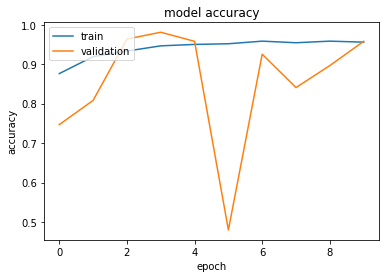

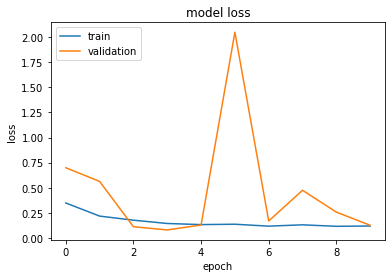

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig('./')

# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('./')
plt.show()

In [27]:
print("Loss of the model is - " , model.evaluate(valid_data)[0])
print("Accuracy of the model is - " , model.evaluate(valid_data)[1]*100 , "%")

33/33 [==============================] - 14s 418ms/step - loss: 0.1010 - accuracy: 0.9674
Loss of the model is -  0.10098635405302048
33/33 [==============================] - 14s 416ms/step - loss: 0.1471 - accuracy: 0.9501
Accuracy of the model is -  95.00959515571594 %


In [28]:
print("Loss of the model is - " , model.evaluate(test_data)[0])
print("Accuracy of the model is - " , model.evaluate(test_data)[1]*100 , "%")

39/39 [==============================] - 150s 4s/step - loss: 0.2444 - accuracy: 0.9215
Loss of the model is -  0.24444980919361115
39/39 [==============================] - 10s 241ms/step - loss: 0.2444 - accuracy: 0.9215
Accuracy of the model is -  92.14743375778198 %


In [29]:
from keras.models import load_model
model.save("PneumoniaDetection.h5")
